- Increased max token length from 256 → 512 to reduce information loss.
- Switched to softer text cleaning to preserve punctuation and technical terms. 
- 52% of abstracts are larger than 256 tokens, after softer cleaning. Before it was around 32%.

Result: Almost every unlabeled abstract is predicted supervised.

## Setup

In [1]:
# Imports

import re
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json
from tqdm import tqdm
import collections

In [2]:
# Paths

data_path = Path("../../data/short-raw-refs-abs")
table_path = Path("../../reports/tables")
figure_path = Path("../../reports/figures")
keywords_path = Path("../../keywords")
processed_abstracts_path = Path("../../data/processed/abstracts")

# Ensure directories exist
for p in [data_path, table_path, figure_path, keywords_path, processed_abstracts_path]:
    p.mkdir(parents=True, exist_ok=True)

print("All directories verified/created.")


All directories verified/created.


In [3]:
# Constants

CREATE_ABSTRACTS_DATASET = True

# Number of topics used for K-means
n_topics = 8

#### Create Abstracts dataset (only need to do this once)

In [4]:
# Helper: Clean Abstracts
# Basic text cleaning

# Light cleaning for model input: keep most of the original signal
def clean_text_for_model(text):
    if not isinstance(text, str):
        return ""

    # Remove copyright statements at the beginning of the abstract
    text = re.sub(r"^©[^\.\n]*\.?\s*", "", text, flags=re.IGNORECASE)

    # Optionally strip URLs and extra whitespace, but keep punctuation, numbers, etc.
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"\s+", " ", text)
    return text.strip()


In [5]:
records = []

if CREATE_ABSTRACTS_DATASET:

    for folder in sorted(data_path.iterdir()):
        if not folder.is_dir():
            continue
        query_id = folder.name
        jsonl_files = list(folder.glob("*.jsonl"))
        for fp in jsonl_files:
            with fp.open("r", encoding="utf-8") as f:
                for line in f:
                    line = line.strip()
                    if not line:
                        continue
                    try:
                        rec = json.loads(line)
                    except json.JSONDecodeError:
                        continue

                    abs_txt = rec.get("abstract") or rec.get("description") or ""
                    if isinstance(abs_txt, list):
                        abs_txt = " ".join(str(x) for x in abs_txt if x)

                    # Cover date was not included in last script
                    records.append({
                        "query_id": query_id,
                        "eid": rec.get("eid"),
                        "doi": rec.get("doi"),
                        "title": rec.get("title"),
                        # "coverDate": rec.get("coverDate"),
                        "abstract": abs_txt.strip()
                    })

    df = pd.DataFrame(records)
    
    # Remove empty abstracts early
    df = df[df["abstract"].notna() & (df["abstract"].str.strip() != "")]
    df = df.reset_index(drop=True)
    
    # Clean abstracts
    df["clean_abs"] = df["abstract"].apply(clean_text_for_model)
    
    print(f"\nCollected {len(df)} abstracts from {len(df['query_id'].unique())} queries")

    # Save for later analysis
    out_path = processed_abstracts_path / "abstracts.csv"
    df.to_csv(out_path, index=False)
    print(f"Saved: {out_path}")



Collected 52290 abstracts from 24 queries
Saved: ../../data/processed/abstracts/abstracts.csv


In [6]:
# Load dataframe with abstracts
# Only if it has been created earlier

if not CREATE_ABSTRACTS_DATASET:
    abstracts_path = processed_abstracts_path / "abstracts.csv"
    df = pd.read_csv(abstracts_path) 
    print(f"Loaded {len(df)} abstracts")


In [7]:
df["doi"].duplicated().sum()

19160

In [8]:
duplicate_dois = df[df["doi"].duplicated(keep=False)].sort_values("doi")
duplicate_dois.head()


,query_id,eid,doi,title,abstract,clean_abs
25166,ml_manufacturing_optimization,2-s2.0-84975815192,10.1002/9781119139508.ch31,Application of machine learning techniques for...,© Copyright 2015 by the Minerals Metals & Mete...,All rights reserved.The use of physics-based s...
20837,ml_manufacturing,2-s2.0-84975815192,10.1002/9781119139508.ch31,Application of machine learning techniques for...,© Copyright 2015 by the Minerals Metals & Mete...,All rights reserved.The use of physics-based s...
20483,ml_manufacturing,2-s2.0-105001294536,10.1002/9781119515326,Prognostics and Health Management of Electroni...,© 2018 John Wiley and Sons Ltd. All rights res...,All rights reserved.An indispensable guide for...
32115,ml_predictive_maintenance,2-s2.0-105001294536,10.1002/9781119515326,Prognostics and Health Management of Electroni...,© 2018 John Wiley and Sons Ltd. All rights res...,All rights reserved.An indispensable guide for...
24368,ml_manufacturing_optimization,2-s2.0-85148252982,10.1002/9781119695868,Industry 4.0 Vision for the Supply of Energy a...,"© 2022 John Wiley and Sons, Inc. All rights re...",All rights reserved.In Industry 4.0 Vision for...


In [9]:
# Count how many rows each query_id has
query_counts = df["query_id"].value_counts().to_dict()

# Create a copy and map the counts to each row
df = df.copy()
df["query_size"] = df["query_id"].map(query_counts)

# Sort so that query groups with fewer rows are prioritized
df_sorted = df.sort_values(by="query_size", ascending=True)

# Remove duplicate DOIs, keeping the one in the smallest query group
df_dedup = df_sorted.drop_duplicates(subset="doi", keep="first").drop(columns=["query_size"])

# Print results
print("Original dataset size:", len(df))
print("After removing duplicates:", len(df_dedup))
print("Remaining duplicate DOIs:", df_dedup["doi"].duplicated().sum())

df = df_dedup

Original dataset size: 52290
After removing duplicates: 33130
Remaining duplicate DOIs: 0


In [10]:
df.head(10)

,query_id,eid,doi,title,abstract,clean_abs
3373,ml_end_of_life,2-s2.0-105019728098,10.1016/B978-0-443-33740-6.00012-8,Blockchain-enabled decision system for reliabl...,© 2026 Elsevier Inc. All rights reserved.As th...,All rights reserved.As the production and cons...
3374,ml_end_of_life,2-s2.0-105018918299,10.1080/19397038.2025.2563271,Systematic review of data modelling methods fo...,© 2025 The Author(s). Published by Informa UK ...,"Published by Informa UK Limited, trading as Ta..."
3387,ml_end_of_life,2-s2.0-105009033696,10.1109/TEMSCON-ASPAC62480.2024.11025082,Clustering Locations of Collection Centers in ...,© 2024 IEEE.Waste generation is a significant ...,Waste generation is a significant issue in sus...
3388,ml_end_of_life,2-s2.0-85178021268,10.1188/23.CJON.595-601,"Artificial Intelligence: Basics, Impact, and H...","© 2023, Oncology Nursing Society. All rights r...",All rights reserved.Applying artificial intell...
3389,ml_end_of_life,2-s2.0-85176777527,10.1039/d3va00106g,Intersections between materials science and ma...,© 2023 RSCPlastics are an integral part of the...,"However, their widespread contamination in the..."
3390,ml_end_of_life,2-s2.0-85174142475,10.3390/asi6050076,Measuring Carbon in Cities and Their Buildings...,© 2023 by the authors.According to the Europea...,"According to the European Green Deal, excessiv..."
3391,ml_end_of_life,2-s2.0-85161673110,10.1016/j.resconrec.2023.107073,Predictive modeling for the quantity of recycl...,© 2023 The Author(s)The rapid development of m...,"However, the Stacking ensemble model is less w..."
3375,ml_end_of_life,2-s2.0-105009218419,10.1007/978-3-031-94484-0_27,Organizational Maturity and Its Influence on P...,"© The Author(s), under exclusive license to Sp...",Life-cycle extension strategies have become cr...
3376,ml_end_of_life,2-s2.0-105008114126,10.1109/ACCESS.2025.3576441,Toward Sustainable Manufacturing: A Review on ...,© 2013 IEEE.In the quest for sustainable manuf...,"In the quest for sustainable manufacturing, th..."
3377,ml_end_of_life,2-s2.0-105003339695,None,Integrating Digital Twins and Robotics,"© 2025 Dr. Syed Saad, Kumeel Rasheed, and Syed...","Syed Saad, Kumeel Rasheed, and Syed Ammad.The ..."


## Analyze with Keywords (Supervised / Unsupervised / Reinforcement)

Each article is classified using keyword matching based on its cleaned abstract.
The classification is **multi-label**, meaning an article may be tagged as
supervised, unsupervised, and/or reinforcement learning depending on which
keywords appear as whole words in the text.

In [11]:
# Gather all keywords 

def load_keyword_file(path: Path) -> list[str]:
    keywords = []
    with path.open("r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if not line or line.startswith("#"):
                continue
            keywords.append(line.lower())
    return keywords


def load_all_keywords(base_dir: Path = keywords_path) -> dict[str, list[str]]:
    return {
        "supervised": load_keyword_file(base_dir / "supervised.txt"),
        "unsupervised": load_keyword_file(base_dir / "unsupervised.txt"),
        "reinforcement": load_keyword_file(base_dir / "reinforcement.txt"),
    }


ml_keywords = load_all_keywords()


In [12]:
# For each ML category, create a binary column (1/0) indicating
# whether any of that category's keywords appear in the cleaned abstract.
# (Uses word-boundary matching so e.g. 'supervised' does NOT match inside 'unsupervised')

def contains_keyword(text, keyword):
    # Escape keyword and enforce word boundaries (\b)
    pattern = rf"\b{re.escape(keyword)}\b"
    return re.search(pattern, text) is not None

for label in ml_keywords.keys():
    df[f"is_{label}"] = df["clean_abs"].apply(
        lambda t, lab=label: any(contains_keyword(str(t).lower(), w) for w in ml_keywords[lab])

    )
    
df.head(2)

,query_id,eid,doi,title,abstract,clean_abs,is_supervised,is_unsupervised,is_reinforcement
3373,ml_end_of_life,2-s2.0-105019728098,10.1016/B978-0-443-33740-6.00012-8,Blockchain-enabled decision system for reliabl...,© 2026 Elsevier Inc. All rights reserved.As th...,All rights reserved.As the production and cons...,False,False,False
3374,ml_end_of_life,2-s2.0-105018918299,10.1080/19397038.2025.2563271,Systematic review of data modelling methods fo...,© 2025 The Author(s). Published by Informa UK ...,"Published by Informa UK Limited, trading as Ta...",False,False,False


In [13]:
# Create a column: "ml_type" that lists all categorys with True

def resolve_label(row):
    labels = []
    if row["is_supervised"]: labels.append("supervised")
    if row["is_unsupervised"]: labels.append("unsupervised")
    if row["is_reinforcement"]: labels.append("reinforcement")
    return labels or ["unknown"]

df["ml_type"] = df.apply(resolve_label, axis=1)

df.head()


,query_id,eid,doi,title,abstract,clean_abs,is_supervised,is_unsupervised,is_reinforcement,ml_type
3373,ml_end_of_life,2-s2.0-105019728098,10.1016/B978-0-443-33740-6.00012-8,Blockchain-enabled decision system for reliabl...,© 2026 Elsevier Inc. All rights reserved.As th...,All rights reserved.As the production and cons...,False,False,False,[unknown]
3374,ml_end_of_life,2-s2.0-105018918299,10.1080/19397038.2025.2563271,Systematic review of data modelling methods fo...,© 2025 The Author(s). Published by Informa UK ...,"Published by Informa UK Limited, trading as Ta...",False,False,False,[unknown]
3387,ml_end_of_life,2-s2.0-105009033696,10.1109/TEMSCON-ASPAC62480.2024.11025082,Clustering Locations of Collection Centers in ...,© 2024 IEEE.Waste generation is a significant ...,Waste generation is a significant issue in sus...,False,True,True,"[unsupervised, reinforcement]"
3388,ml_end_of_life,2-s2.0-85178021268,10.1188/23.CJON.595-601,"Artificial Intelligence: Basics, Impact, and H...","© 2023, Oncology Nursing Society. All rights r...",All rights reserved.Applying artificial intell...,False,False,False,[unknown]
3389,ml_end_of_life,2-s2.0-85176777527,10.1039/d3va00106g,Intersections between materials science and ma...,© 2023 RSCPlastics are an integral part of the...,"However, their widespread contamination in the...",False,False,False,[unknown]


In [14]:
# Frequency of each ML category
df["ml_type"].explode().value_counts()

ml_type
unknown          18955
supervised       10915
unsupervised      3600
reinforcement     1733
Name: count, dtype: int64

In [15]:
# Frequency for each query
df.explode("ml_type").groupby(["query_id", "ml_type"]).size().unstack(fill_value=0)

ml_type,reinforcement,supervised,unknown,unsupervised
query_id,,,,
ml_anomaly_detection_production,15,238,67,505
ml_automation,83,206,691,82
ml_defect_detection,13,273,285,100
ml_disassembly,15,92,158,24
ml_end_of_life,9,13,28,3
ml_inservice_monitoring,53,284,445,93
ml_manufacturing,342,2588,4711,748
ml_manufacturing_optimization,152,641,1249,131
ml_planning_production,168,637,878,133


In [16]:
# Percentage of abstracts that mention each ML category
df[["is_supervised", "is_unsupervised", "is_reinforcement"]].mean()

is_supervised       0.329460
is_unsupervised     0.108663
is_reinforcement    0.052309
dtype: float64

<Axes: xlabel='ml_type'>

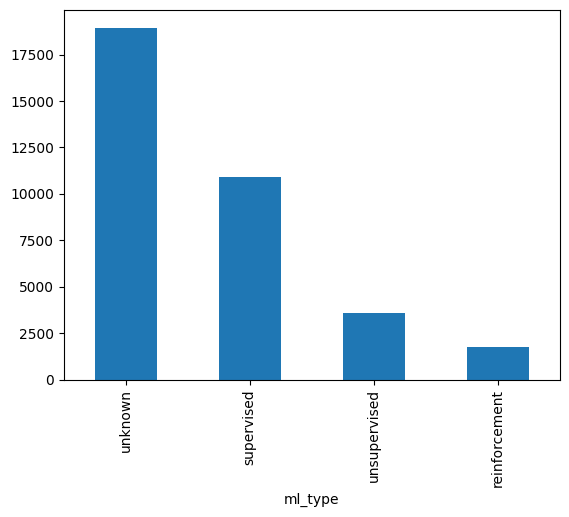

In [17]:
# Plot frequency of ML categories across all abstracts
df["ml_type"].explode().value_counts().plot(kind="bar")

In [18]:
# Sample of abstracts that were classified as "unknown"
# Should analyze to improve keyword sets
df[df["ml_type"].apply(lambda x: x == ["unknown"])].sample(2)


,query_id,eid,doi,title,abstract,clean_abs,is_supervised,is_unsupervised,is_reinforcement,ml_type
48009,ml_robotics_production,2-s2.0-85216632224,10.1201/9781003494478-7,Advancements in mechatronic systems for manufa...,"© 2025 selection and editorial matter, Ajay Ku...",Modern mechatronics has transformed automation...,False,False,False,[unknown]
4315,ml_inservice_monitoring,2-s2.0-34147216227,10.1360/crad20070105,Effective approach to automatic semantic annot...,"In service grid, the implementation of distrib...","In service grid, the implementation of distrib...",False,False,False,[unknown]


### Notes on Keyword-Based Classification

The keyword approach provides a simple first pass, but it has clear limitations:
- Many abstracts are labeled **unknown** because keywords may be absent, implicit, or expressed differently.
- Some methods overlap terminology (e.g., “semi-supervised”), which can lead to misclassification.
- Context is ignored, so the presence of a term does not guarantee it is the main ML method.

These limitations explain the large number of “unknown” cases and motivate using a more robust model-based classifier later.

## Training a Multi-Label ML-Method Classifier Using Keyword Pseudo-Labels

- The keyword-based approach provides noisy but useful initial labels for each article (e.g., supervised / unsupervised / reinforcement).  
- In the following steps, we use these pseudo-labels to train a **multi-label transformer model** (e.g., SciBERT or DistilBERT) on the abstracts. 
- This allows the model to learn richer linguistic patterns and produce more accurate classifications than the raw keyword method, while requiring **no manual labeling up front**.


In [19]:
import torch
print(torch.__version__)

2.9.1+cu128


In [20]:
from datasets import Dataset
import numpy as np

label_cols = ["is_supervised", "is_unsupervised", "is_reinforcement"]

# Keep only rows that have at least one positive label (optional but often useful)
df_model = df.copy()
mask_any_label = df_model[label_cols].sum(axis=1) > 0
df_model = df_model[mask_any_label].reset_index(drop=True)

print(df_model[label_cols].mean())  # quick check of label frequencies

dataset = Dataset.from_pandas(df_model[["clean_abs"] + label_cols])

# Train/validation split
splits = dataset.train_test_split(test_size=0.2, seed=42)
train_ds = splits["train"]
val_ds = splits["test"]



/cluster/home/mbergst/.venvs/ml-catalogue/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


is_supervised       0.770018
is_unsupervised     0.253968
is_reinforcement    0.122257
dtype: float64


In [21]:
# Ensure scibert directory exists
scibert_path = processed_abstracts_path / "scibert_2"
scibert_path.mkdir(parents=True, exist_ok=True)

# Save datasets
train_path = scibert_path / "train_ds.csv"
val_path = scibert_path / "val_ds.csv"

train_ds.to_csv(train_path, index=False)
val_ds.to_csv(val_path, index=False)

print(f"Saved train_ds to: {train_path}")
print(f"Saved val_ds to:   {val_path}")

Creating CSV from Arrow format: 100%|██████████| 3/3 [00:00<00:00, 29.39ba/s]

Saved train_ds to: ../../data/processed/abstracts/scibert_2/train_ds.csv
Saved val_ds to:   ../../data/processed/abstracts/scibert_2/val_ds.csv


In [22]:
train_ds.to_pandas().head()


,clean_abs,is_supervised,is_unsupervised,is_reinforcement
0,", part of Springer Nature 2024.Additive manufa...",False,True,False
1,Predictive maintenance solutions have been rec...,True,False,False
2,Businesses and software development processes ...,False,False,True
3,Knowledge of such activity often desires frequ...,True,False,False
4,The long-sought prediction pipelines for solid...,True,False,False


In [23]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

model_name = "allenai/scibert_scivocab_uncased"  # or "distilbert-base-uncased"

tokenizer = AutoTokenizer.from_pretrained(model_name)

label_cols = ["is_supervised", "is_unsupervised", "is_reinforcement"]

# Add a single multi-label 'labels' column
def add_labels(example):
    example["labels"] = [float(example[c]) for c in label_cols]
    return example

train_ds_l = train_ds.map(add_labels)
val_ds_l   = val_ds.map(add_labels)

def tokenize_batch(batch):
    return tokenizer(
        batch["clean_abs"],
        padding="max_length",
        truncation=True,
        max_length=512,
    )

train_ds_tok = train_ds_l.map(tokenize_batch, batched=True)
val_ds_tok   = val_ds_l.map(tokenize_batch, batched=True)

def set_format(ds):
    return ds.with_format(
        type="torch",
        columns=["input_ids", "attention_mask", "labels"],
    )

train_ds_tok = set_format(train_ds_tok)
val_ds_tok   = set_format(val_ds_tok)

model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=len(label_cols),
    problem_type="multi_label_classification",
)


Map: 100%|██████████| 2835/2835 [00:00<00:00, 3032.56 examples/s]
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at allenai/scibert_scivocab_uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [24]:
# Compute average number of tokens per abstract using the tokenizer

lengths = []

for text in df["clean_abs"].tolist():
    enc = tokenizer(
        text,
        truncation=True,
        max_length=2048,
    )
    lengths.append(len(enc["input_ids"]))

avg_len = sum(lengths) / len(lengths)
max_len = max(lengths)
min_len = min(lengths)

print(f"Average token length: {avg_len:.2f}")
print(f"Min tokens: {min_len}, Max tokens: {max_len}")


Average token length: 259.59
Min tokens: 2, Max tokens: 2048


In [25]:
# Count how many abstracts exceed various token-length thresholds

thresholds = [256, 512, 768, 1024, 1500]

lengths = []
for text in df["clean_abs"].tolist():
    enc = tokenizer(text, truncation=False)   # do NOT truncate → get true length
    lengths.append(len(enc["input_ids"]))

results = {}
for t in thresholds:
    results[t] = sum(l > t for l in lengths)

print("Token length distribution:")
for t, count in results.items():
    print(f" > {t:4d} tokens : {count} abstracts")

# Optional: also show % of dataset
n = len(lengths)
print("\nPercentages:")
for t, count in results.items():
    print(f" > {t:4d} tokens : {count/n*100:.2f}%")


Token length distribution:
 >  256 tokens : 14734 abstracts
 >  512 tokens : 671 abstracts
 >  768 tokens : 127 abstracts
 > 1024 tokens : 55 abstracts
 > 1500 tokens : 4 abstracts

Percentages:
 >  256 tokens : 44.47%
 >  512 tokens : 2.03%
 >  768 tokens : 0.38%
 > 1024 tokens : 0.17%
 > 1500 tokens : 0.01%


In [26]:
# Check cuda version etc for debugging

print(torch.version.cuda)
print(torch.cuda.get_device_name())
print(torch.cuda.get_device_capability())
print(torch.cuda.get_arch_list())

12.8
NVIDIA A100-PCIE-40GB
(8, 0)
['sm_70', 'sm_75', 'sm_80', 'sm_86', 'sm_90', 'sm_100', 'sm_120']


In [27]:
from transformers import TrainingArguments, Trainer
from sklearn.metrics import f1_score, precision_score, recall_score

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    probs = 1 / (1 + np.exp(-logits))           # sigmoid
    preds = (probs >= 0.5).astype(int)

    # Flatten over labels
    return {
        "f1_micro": f1_score(labels, preds, average="micro", zero_division=0),
        "f1_macro": f1_score(labels, preds, average="macro", zero_division=0),
        "precision_micro": precision_score(labels, preds, average="micro", zero_division=0),
        "recall_micro": recall_score(labels, preds, average="micro", zero_division=0),
    }

training_args = TrainingArguments(
    output_dir="./ml_type_model",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="f1_micro",
    logging_steps=50,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds_tok,
    eval_dataset=val_ds_tok,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

trainer.train()


/tmp/ipykernel_3440493/310402851.py:31: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,F1 Micro,F1 Macro,Precision Micro,Recall Micro
1,0.035000,0.041078,0.985712,0.979707,0.981640,0.989818
2,0.010500,0.016383,0.994913,0.993455,0.994147,0.995680
3,0.010600,0.012650,0.995989,0.994995,0.995989,0.995989


TrainOutput(global_step=2127, training_loss=0.05152849499950624, metrics={'train_runtime': 763.9911, 'train_samples_per_second': 44.529, 'train_steps_per_second': 2.784, 'total_flos': 8951118471106560.0, 'train_loss': 0.05152849499950624, 'epoch': 3.0})

In [28]:
# Tune thresholds based on validation set

logits_val, labels_val = trainer.predict(val_ds_tok)[:2]
probs_val = 1 / (1 + np.exp(-logits_val))

best_thresholds = {}

for i, col in enumerate(label_cols):
    best_f1 = 0.0
    best_t = 0.5
    for t in np.linspace(0.1, 0.9, 17):  # Try thresholds between 0.1 and 0.9
        preds = (probs_val[:, i] >= t).astype(int)
        f1 = f1_score(labels_val[:, i], preds, zero_division=0)
        if f1 > best_f1:
            best_f1 = f1
            best_t = t
    best_thresholds[col] = best_t

print("Best thresholds:", best_thresholds)


Best thresholds: {'is_supervised': 0.65, 'is_unsupervised': 0.2, 'is_reinforcement': 0.1}


In [ ]:
def predict_ml_types_batched(texts, trainer, threshold=0.5, batch_size=64, max_length=512):
    all_preds = []
    all_probs = []

    model = trainer.model
    model.eval()

    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i + batch_size]

        enc = tokenizer(
            batch_texts,
            padding=True,
            truncation=True,
            max_length=max_length,
            return_tensors="pt",
        )
        enc = {k: v.to(model.device) for k, v in enc.items()}

        with torch.no_grad():
            logits = model(**enc).logits

        probs = torch.sigmoid(logits).cpu().numpy()
        preds = (probs >= threshold).astype(int)

        all_probs.append(probs)
        all_preds.append(preds)

    all_probs = np.vstack(all_probs)
    all_preds = np.vstack(all_preds)
    return all_preds, all_probs


texts = df["clean_abs"].tolist()
preds, probs = predict_ml_types_batched(texts, trainer, batch_size=64, threshold=0.5)

for i, col in enumerate(label_cols):
    df[f"pred_{col}"] = preds[:, i]


TypeError: TextEncodeInput must be Union[TextInputSequence, Tuple[InputSequence, InputSequence]]

In [ ]:
for i, col in enumerate(label_cols):
    df[f"pred_{col}"] = preds[:, i]

pred_cols = [f"pred_{c}" for c in label_cols]
cols_to_save = [
    "query_id", "eid", "doi", "title", "abstract", "clean_abs",
] + label_cols + pred_cols

save_path = scibert_path / "abstracts_with_predictions.csv"
df[cols_to_save].to_csv(save_path, index=False)

print(f"Saved predictions to: {save_path}")

Saved predictions to: ../../data/processed/abstracts/scibert_2/abstracts_with_predictions.csv


## Analyze Scibert Predictions

In [ ]:
pred_path = Path("../../data/processed/abstracts/scibert_2/abstracts_with_predictions.csv")

pred_cols = ["pred_is_supervised","pred_is_unsupervised","pred_is_reinforcement"]

In [ ]:
df = pd.read_csv(pred_path)
df.head()

,query_id,eid,doi,title,abstract,clean_abs,is_supervised,is_unsupervised,is_reinforcement,pred_is_supervised,pred_is_unsupervised,pred_is_reinforcement
0,ml_end_of_life,2-s2.0-105019728098,10.1016/B978-0-443-33740-6.00012-8,Blockchain-enabled decision system for reliabl...,© 2026 Elsevier Inc. All rights reserved.As th...,All rights reserved.As the production and cons...,False,False,False,0,0,1
1,ml_end_of_life,2-s2.0-105018918299,10.1080/19397038.2025.2563271,Systematic review of data modelling methods fo...,© 2025 The Author(s). Published by Informa UK ...,"Published by Informa UK Limited, trading as Ta...",False,False,False,0,0,1
2,ml_end_of_life,2-s2.0-105009033696,10.1109/TEMSCON-ASPAC62480.2024.11025082,Clustering Locations of Collection Centers in ...,© 2024 IEEE.Waste generation is a significant ...,Waste generation is a significant issue in sus...,False,True,True,0,1,1
3,ml_end_of_life,2-s2.0-85178021268,10.1188/23.CJON.595-601,"Artificial Intelligence: Basics, Impact, and H...","© 2023, Oncology Nursing Society. All rights r...",All rights reserved.Applying artificial intell...,False,False,False,0,0,1
4,ml_end_of_life,2-s2.0-85176777527,10.1039/d3va00106g,Intersections between materials science and ma...,© 2023 RSCPlastics are an integral part of the...,"However, their widespread contamination in the...",False,False,False,0,0,1


In [ ]:
df[pred_cols].mean()

pred_is_supervised       0.382795
pred_is_unsupervised     0.163538
pred_is_reinforcement    0.471687
dtype: float64

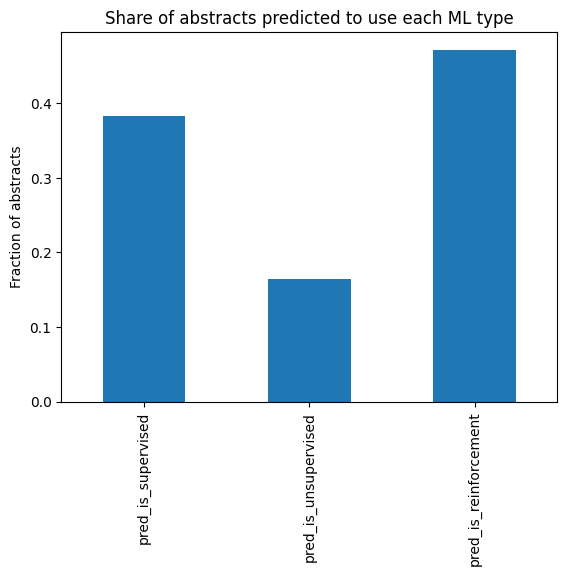

In [ ]:
df[pred_cols].mean().plot(kind="bar")
plt.title("Share of abstracts predicted to use each ML type")
plt.ylabel("Fraction of abstracts")
plt.show()

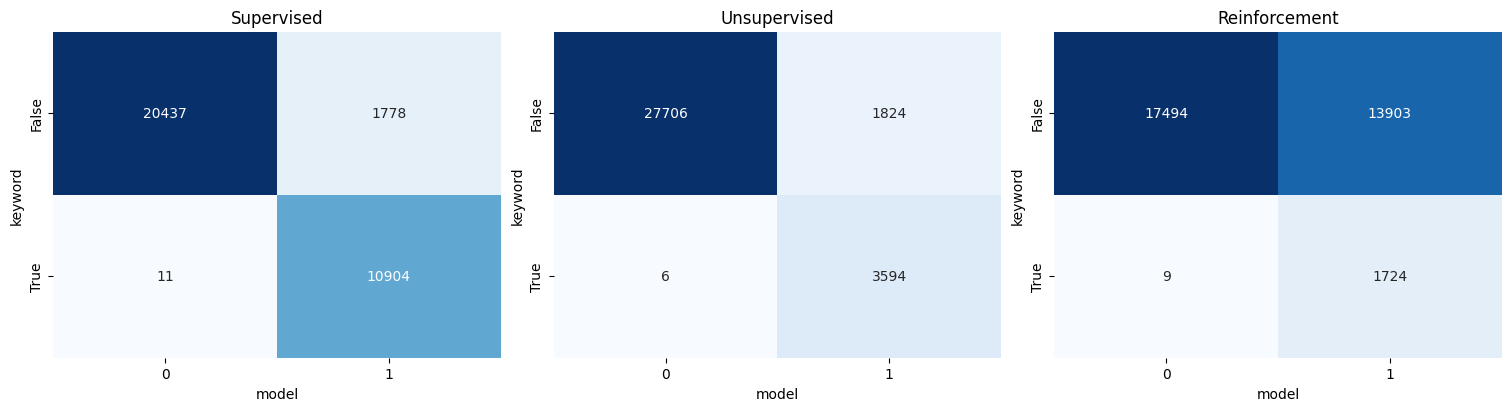

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4), constrained_layout=True)

for ax, col in zip(axes, label_cols):
    ctab = pd.crosstab(df[col], df[f"pred_{col}"], rownames=["keyword"], colnames=["model"])
    
    sns.heatmap(
        ctab,
        annot=True,
        fmt="d",
        cmap="Blues",
        cbar=False,
        ax=ax
    )
    ax.set_title(col.replace("is_", "").capitalize())

plt.show()


In [ ]:
# Small per-label stats
for col in label_cols:
    pred = df[f"pred_{col}"]
    true = df[col]

    tp = ((true == 1) & (pred == 1)).sum()
    fp = ((true == 0) & (pred == 1)).sum()
    fn = ((true == 1) & (pred == 0)).sum()
    tn = ((true == 0) & (pred == 0)).sum()

    print(
        f"\n=== {col} ===\n"
        f"TP: {tp}\nFP: {fp}\nFN: {fn}\nTN: {tn}\n"
        f"Precision: {tp/(tp+fp+1e-9):.3f}\n"
        f"Recall:    {tp/(tp+fn+1e-9):.3f}\n"
    )



=== is_supervised ===
TP: 10904
FP: 1778
FN: 11
TN: 20437
Precision: 0.860
Recall:    0.999


=== is_unsupervised ===
TP: 3594
FP: 1824
FN: 6
TN: 27706
Precision: 0.663
Recall:    0.998


=== is_reinforcement ===
TP: 1724
FP: 13903
FN: 9
TN: 17494
Precision: 0.110
Recall:    0.995



In [ ]:
# Extract a few rows where the model disagrees with keyword labels (only among keyword-labeled rows)

mask_labeled = df[label_cols].sum(axis=1) > 0
mask_disagree = (df[[f"pred_{c}" for c in label_cols]].values != df[label_cols].values).any(axis=1)

df_mismatch = df[mask_labeled & mask_disagree]

df_mismatch.sample(10)[
    ["doi", "title", "clean_abs"] 
    + label_cols 
    + [f"pred_{c}" for c in label_cols]
]


,doi,title,clean_abs,is_supervised,is_unsupervised,is_reinforcement,pred_is_supervised,pred_is_unsupervised,pred_is_reinforcement
7431,10.1016/j.procs.2015.04.047,Machine learning approach to the prediction of...,Published by Elsevier B.V.Prediction of surfac...,True,False,False,1,1,0
24212,10.1007/s00170-024-14832-w,Data-driven flatness presetting control ensemb...,", part of Springer Nature 2024.The presetting ...",False,True,False,1,1,0
31068,10.3788/CJL240497,Applications of Raman Spectroscopy Technology ...,All rights reserved.Significance The cornea is...,True,True,True,1,0,0
4483,10.11834/jig.200469,Technologies of virtual scenario construction ...,All right reserved.With the continuous improve...,False,False,True,1,0,1
25053,10.1007/s00202-025-03277-3,Advanced hybrid machine learning models for en...,Electricity provides the essential drive for s...,False,False,True,1,0,1
2029,10.15157/IJITIS.2025.8.1.272-293,Unveiling Anomalies: Leveraging Machine Learni...,Insider threats pose a significant risk to org...,False,True,False,1,1,0
6894,10.1016/j.jretconser.2025.104227,Exploring sustainable consumer behaviour in re...,"Utilizing a structured, dual-model framework, ...",False,False,True,1,0,1
31463,10.1007/978-3-031-80154-9_3,Advancements in AI-Based Anomaly Detection for...,In theIndustry 4.0 IndustryAI-based Anomaly De...,True,True,False,1,1,1
1808,10.1117/12.3052252,AI-Powered End-to-End Product Lifecycle: UX-Ce...,"As the amount of data continues to grow, with ...",True,True,False,0,1,0
19146,10.1109/ACCAI61061.2024.10601981,Predictive Maintenance of Electrical Machines ...,Predictive maintenance improves electrical mac...,False,True,False,1,1,0


In [ ]:
# Compare prediction counts for rows used in training vs rows not used in training

# Identify which rows were used for training (those with at least one keyword-label = 1)
mask_train = df[label_cols].sum(axis=1) > 0
mask_not_train = ~mask_train

# Count predicted positives per class for train rows
pred_cols = [f"pred_{c}" for c in label_cols]

pred_counts_train = df[mask_train][pred_cols].sum()
pred_counts_not_train = df[mask_not_train][pred_cols].sum()

print("=== Predictions on TRAINED rows ===")
print(pred_counts_train)
print("\n=== Predictions on NON-TRAINED rows ===")
print(pred_counts_not_train)


=== Predictions on TRAINED rows ===
pred_is_supervised       10916
pred_is_unsupervised      3606
pred_is_reinforcement     1727
dtype: int64

=== Predictions on NON-TRAINED rows ===
pred_is_supervised        1766
pred_is_unsupervised      1812
pred_is_reinforcement    13900
dtype: int64
